In [1]:
device = 'cuda:0'

In [2]:
import numpy as np

# Generate trajectory (3 timestep traj for now -> generalize into T timestep)
def get_ref_trajectory(start_loc_org, target_loc_org, intersection_point, ratio=None, scale=0.1):
    assert type(scale) in {float, int} or len(scale) == len(start_loc_org)
    
    xp = np.linspace(0, 1, len(intersection_point)+2)
    
    inter_point = np.stack([start_loc_org, *intersection_point, target_loc_org], axis=0)

    if ratio is None:
        ratio = xp
    
    ref_trajectory = np.stack([np.interp(ratio, xp, inter_point[:, 0]), np.interp(ratio, xp, inter_point[:, 1])], axis=1)
    ref_trajectory = ref_trajectory + scale * np.random.randn(*ref_trajectory.shape)
    
    return ref_trajectory

(128, 16)


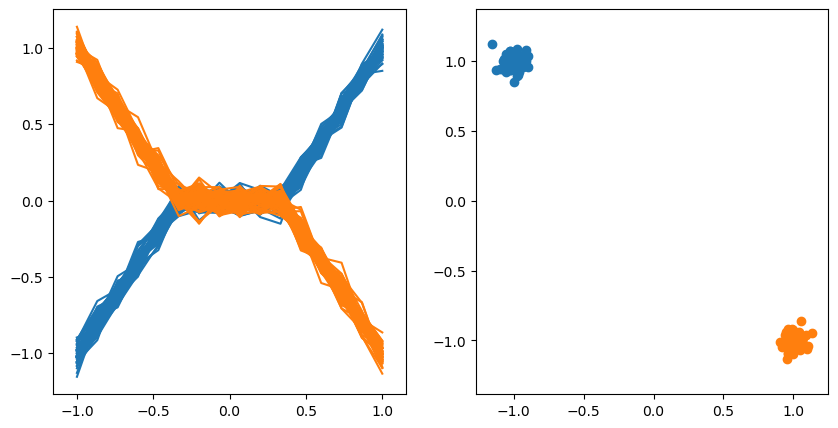

In [3]:
# Plot the trajectory and its datapoint on R^T space

def get_data(num_trajectories):
        
    # print(f"[ environments/maze2d ] getting dataset for {dataname}")
    
    # dataset = collections.defaultdict(list)            
    # for key in ['observations', 'actions', 'rewards', 'terminals', 'info/goal', 'info/qpos', 'info/qvel']:
    #     dataset[key] = []
    
    intersection_point = [[-3.33, 0], [3.33, 0]]
    # intersection_point = [[0, 0]]

    ratio = np.linspace(0, 1, 16)
    
    scale = 0.05

    start_loc_org = np.array([-1, -1], dtype=float)
    target_loc_org = np.array([1, 1], dtype=float)
    
    trajectories_lst = []
    for _ in range(num_trajectories//2):
        ref_trjectory = get_ref_trajectory(start_loc_org, target_loc_org, intersection_point, ratio, scale=scale)
        trajectories_lst.append(ref_trjectory)
        
    start_loc_org = np.array([-1, 1], dtype=float)
    target_loc_org = np.array([1, -1], dtype=float)
    
    for _ in range(num_trajectories//2):
        ref_trjectory = get_ref_trajectory(start_loc_org, target_loc_org, intersection_point, ratio, scale=scale)
        trajectories_lst.append(ref_trjectory)        

    # start_loc_org = np.array([-1, -1], dtype=float)
    # target_loc_org = np.array([1, -1], dtype=float)
    
    # for _ in range(num_trajectories//4):
    #     ref_trjectory = get_ref_trajectory(start_loc_org, target_loc_org, intersection_point, ratio, scale=scale)
    #     trajectories_lst.append(ref_trjectory)

    # start_loc_org = np.array([-1, 1], dtype=float)
    # target_loc_org = np.array([1, 1], dtype=float)
    
    # for _ in range(num_trajectories//4):
    #     ref_trjectory = get_ref_trajectory(start_loc_org, target_loc_org, intersection_point, ratio, scale=scale)
    #     trajectories_lst.append(ref_trjectory)

    trajectories = np.stack(trajectories_lst)[:, :, 1]
    
    return trajectories

# def get_data(num_trajectories):

#     trajectory_lst = []

#     start_loc = np.array([-1, -1])
#     intersection = np.array([[-0.66, -0.66], [-0.33, -0.33], [0, 0], [0.33, 0.33], [0.66, 0.66]])
#     target_loc = np.array([1, 1])
    
#     # start_loc = np.array([-1, 0])
#     # intersection = np.array([[-0.5, 1], [0, 0], [0.5, -1]])
#     # target_loc = np.array([1, 0])
#     for _ in range(num_trajectories//2):
#         trajectory_lst.append(get_ref_trajectory(start_loc, target_loc, intersection, scale=[0, 0.1]))

#     start_loc = np.array([-1, 1])
#     intersection = np.array([[-0.66, 0.66], [-0.33, 0.33], [0, 0], [0.33, -0.33], [0.66, -0.66]])
#     target_loc = np.array([1, -1])
#     # start_loc = np.array([-1, 0])
#     # intersection = np.array([[-0.5, -1], [0, 0], [0.5, 1]])
#     # target_loc = np.array([1, 0])
#     for _ in range(num_trajectories//2):
#         trajectory_lst.append(get_ref_trajectory(start_loc, target_loc, intersection, scale=[0, 0.1]))

#     trajectories = np.array(trajectory_lst)[:, : ,1]

#     return trajectories

from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

trajectories = get_data(128)
print(trajectories.shape)

x = np.repeat(np.expand_dims(np.linspace(-1, 1, trajectories.shape[1]), axis=0), [trajectories.shape[0]], axis=0)
ax[0].plot(x[:trajectories.shape[0]//2, :].T, trajectories[:trajectories.shape[0]//2, :].T, c='tab:blue');
ax[0].plot(x[trajectories.shape[0]//2:, :].T, trajectories[trajectories.shape[0]//2:, :].T, c='tab:orange');
ax[0].axis('equal');

def extract_dimension(array, dim_lst):
    return array[:, dim_lst]

trajectories = extract_dimension(trajectories, [0, -1])
ax[1].scatter(trajectories[:trajectories.shape[0]//2, 0], trajectories[:trajectories.shape[0]//2, 1])
ax[1].scatter(trajectories[trajectories.shape[0]//2:, 0], trajectories[trajectories.shape[0]//2:, 1])
ax[1].axis('equal');

In [4]:
# implement DSM
import torch
from torch.autograd import grad
from torch import nn

# Score Estimation Network
class EnergyNet(nn.Module):
    def __init__(self, input_dim=3, hidden_dim = 256, normalize = 'default'):
        super().__init__()
        self.foward_1 = nn.Linear(input_dim, hidden_dim)
        self.foward_2 = nn.Linear(hidden_dim, hidden_dim)
        self.foward_3 = nn.Linear(hidden_dim, 1)

        if normalize == 'default':
            def normalize(x):
                return x
        elif normalize == 'batch_norm':
            self.batch_norm_layer = nn.BatchNorm1d(num_features=2)
            def normalize(x):
                return self.batch_norm_layer(x)
        elif normalize == 'standard':
            def normalize(x):
                norm_min, norm_max = x.min().clone().detach(), x.max().clone().detach()
                normalized_data = (x - norm_min)/(norm_max-norm_min)
                norm_mean = normalized_data.mean().clone().detach()
                normalized_data = normalized_data - norm_mean

                return normalized_data
        else:
            raise NotImplementedError
        self.normalize = normalize

    def forward(self, x):
        # print(x.shape)
        x = self.normalize(x)
        # print(x.shape)
        self.normalized_data = x.clone().detach()
        x = nn.GELU()(self.foward_1(x))
        x = nn.GELU()(self.foward_2(x))
        x = (self.foward_3(x))
        
        return x
    
# LangevinSampler
class LangevinSampler:
    """Langevin Monte Carlo Sampler"""
    def __init__(self, n_step, stepsize, noise_std):
        self.n_step = n_step
        self.stepsize = stepsize
        self.noise_std = noise_std

    def sample(self, x_init, energy_fn):
        x = x_init.clone()
        x.requires_grad = True
        for i_step in range(self.n_step):
            energy = energy_fn(x)
            g = grad(energy.sum(), x, create_graph=True)[0]
            x = x - self.stepsize * g + torch.randn_like(x) * self.noise_std
        return x.detach()
    
    def sample_from_score(self, x_init, score_fn):
        x = x_init.clone()
        for i_step in range(self.n_step):
            score = score_fn(x)
            x = x + self.stepsize * score + torch.randn_like(x) * self.noise_std
        return x.detach()

In [5]:
from torch.optim import Adam

# Bring score estimation model
trajectories = get_data(4)
energy_model = EnergyNet(input_dim=trajectories.shape[1], hidden_dim=128).to(device=device)

# Bring optimizer
opt = Adam(energy_model.parameters(), lr=0.0001)

# Bring LangevinSampler
langevin_sampler = LangevinSampler(n_step=5000, stepsize=0.01, noise_std=0.05)

In [6]:
# Train score model
from tqdm import tqdm

sigma = 0.1
batch_size = 128
training_step = 8000

loss_lst = []

loss_lst_lst = []
sampled_trajectories_lst = []
sampled_vectorfield_lst = []

for i in tqdm(range(training_step)):
    opt.zero_grad()

    # get noised data
    train_data = torch.from_numpy(get_data(batch_size)).to(dtype=torch.float32).to(device=device)
    noise_z = np.random.multivariate_normal(np.zeros(train_data.shape[1]), cov=np.eye(train_data.shape[1]), size=train_data.shape[0])
    noise_z = torch.tensor(noise_z, dtype=torch.float).to(device=device)
    train_data_noise = train_data + sigma * noise_z
    train_data_noise.requires_grad = True

    energy = energy_model(train_data_noise)

    score = -grad(energy.sum(), train_data_noise, create_graph=True)[0]

    loss = torch.norm(noise_z/sigma + score, dim=-1)**2
    loss = 1/2 * loss.mean()
    
    loss.backward()
    opt.step()
    loss_lst.append(loss.clone().detach().cpu().item())

    if i % (training_step//3) == 0:
        loss_lst_lst.append(loss_lst.copy())

        # sample data
        x0 = torch.randn_like(train_data)
        sampled_trajectories = langevin_sampler.sample(x0, energy_model)
        sampled_trajectories_lst.append(sampled_trajectories.clone().detach().cpu().numpy())

100%|██████████| 8000/8000 [00:42<00:00, 188.52it/s]


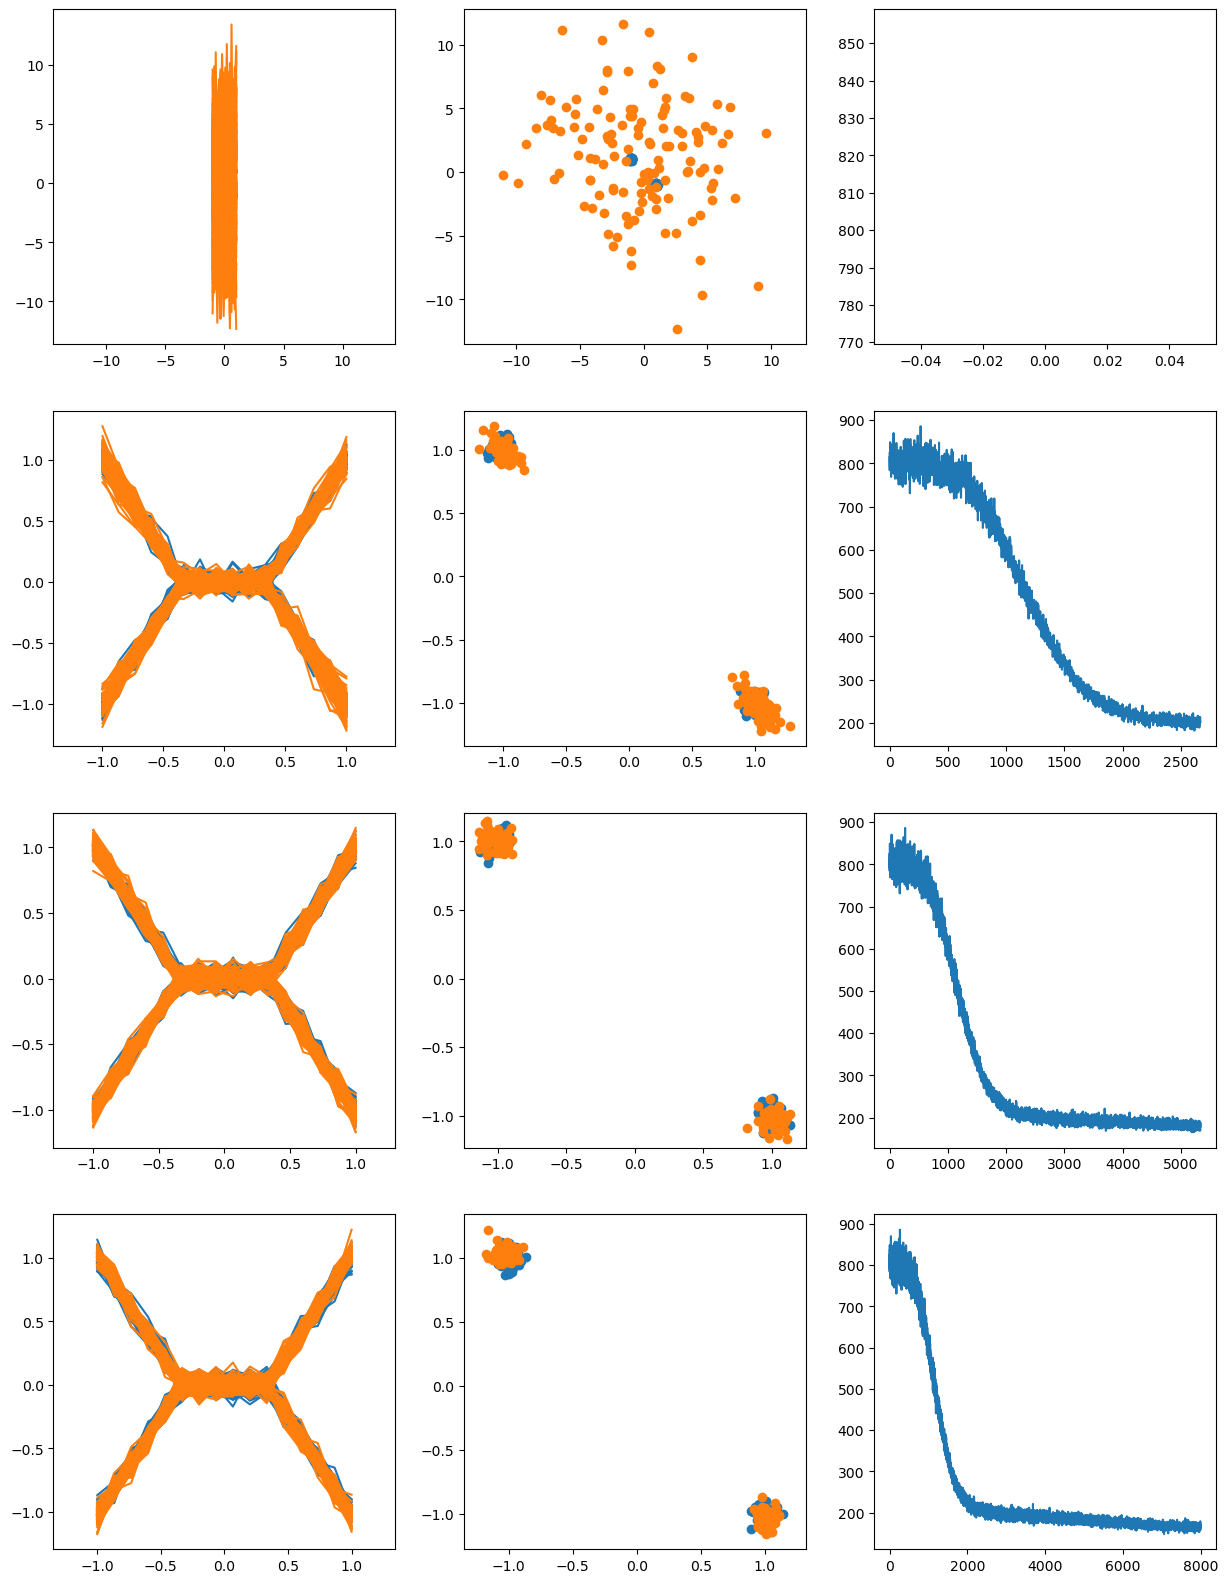

In [7]:
# Plot the sampled trajectory and its datapoit on R^T space

fig, ax = plt.subplots(len(loss_lst_lst), 3, figsize=(15, 5*len(loss_lst_lst)))

for i, (loss_lst, sampled_trajectories) in enumerate(zip(loss_lst_lst, sampled_trajectories_lst)):

    x = np.repeat(np.expand_dims(np.linspace(-1, 1, sampled_trajectories.shape[1]), axis=0), [sampled_trajectories.shape[0]], axis=0)
    trajectories = get_data(sampled_trajectories.shape[0])

    ax[i, 0].plot(x.T, trajectories.T, c='tab:blue');
    ax[i, 0].plot(x.T, sampled_trajectories.T, c='tab:orange');
    ax[i, 0].axis('equal');
    axis = [0, -1]
    
    sampled_trajectories_ = extract_dimension(sampled_trajectories, axis)
    trajectories_ = extract_dimension(trajectories, axis)

    ax[i, 1].scatter(trajectories_[:, 0], trajectories_[:, 1])
    ax[i, 1].scatter(sampled_trajectories_[:, 0], sampled_trajectories_[:, 1])
    ax[i, 1].axis('equal')
    
    ax[i, 2].plot(loss_lst)
    


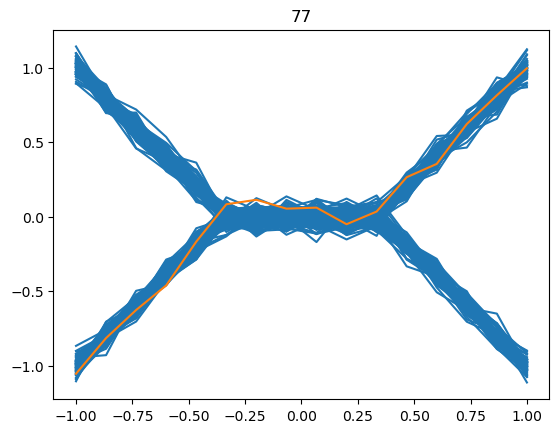

In [8]:
x = np.repeat(np.expand_dims(np.linspace(-1, 1, sampled_trajectories.shape[1]), axis=0), [sampled_trajectories.shape[0]], axis=0)
n = int(np.random.uniform(0, len(sampled_trajectories)))
plt.plot(x.T, trajectories.T, c='tab:blue');
plt.plot(x[0], sampled_trajectories[n], c='tab:orange');
plt.title(n);

In [9]:
# implment Stitch DSM

# For stitched DSM in T timestep trajectory, we need 2(T-1) networks (p(T-2)...p(0) & p(T-1;T-2)...p(1;0))

dummy_dataset = get_data(4)
T = dummy_dataset.shape[1]
joint_energy_model_lst = [EnergyNet(input_dim=2).to(device=device) for _ in range(T-1)]
marginal_energy_model_lst = [EnergyNet(input_dim=1).to(device=device) for _ in range(T-1)]

# Bring optimizer
opt_parameter = []
for joint_energy_model, marginal_energy_model in zip(joint_energy_model_lst, marginal_energy_model_lst):
    opt_parameter.extend([*joint_energy_model.parameters(), *marginal_energy_model.parameters()])
opt = Adam(opt_parameter, lr=0.0001)

# Bring LangevinSampler
langevin_sampler = LangevinSampler(n_step=5000, stepsize=0.01, noise_std=0.05)

In [10]:
# Train score model
from tqdm import tqdm

sigma = 0.1
batch_size = 128 * 16
training_step = 8000

stitch_loss_lst = []

stitch_loss_lst_lst = []
stitch_sampled_trajectories_lst = []

for i in tqdm(range(training_step)):
    opt.zero_grad()

    # get noised data
    train_data = torch.from_numpy(get_data(batch_size)).to(dtype=torch.float32).to(device=device)
    noise_z = np.random.multivariate_normal(np.zeros(train_data.shape[1]), cov=np.eye(train_data.shape[1]), size=train_data.shape[0])
    noise_z = torch.tensor(noise_z, dtype=torch.float).to(device=device)
    train_data_noise = train_data + sigma * noise_z
    
    loss = 0
    for t in range(T-1):
        joint_energy_model = joint_energy_model_lst[t]
        marginal_energy_model = marginal_energy_model_lst[t]
        
        joint_energy_model_input = train_data_noise[:, [t, t+1]].clone().requires_grad_()
        joint_energy = joint_energy_model(joint_energy_model_input)
        joint_score = -grad(joint_energy.sum(), joint_energy_model_input, create_graph=True)[0]
        joint_loss = torch.norm(noise_z[:, [t, t+1]]/sigma + joint_score, dim=-1)**2
        loss += 1/2 * joint_loss.mean()
        
        marginal_energy_input = train_data_noise[:, t:t+1].clone().requires_grad_()
        marginal_energy = marginal_energy_model(marginal_energy_input)
        marginal_score = -grad(marginal_energy.sum(), marginal_energy_input, create_graph=True)[0]
        marginal_loss = torch.norm(noise_z[:, t:t+1]/sigma + marginal_score, dim=-1)**2
        loss += 1/2 * marginal_loss.mean()
    
    loss.backward()
    opt.step()
    stitch_loss_lst.append(loss.clone().detach().cpu().item())

    if i % (training_step//5) == 0:
        stitch_loss_lst_lst.append(stitch_loss_lst.copy())

        # sample data
        x0 = torch.randn_like(train_data)
        
        def get_score(x):
            total_score = torch.zeros_like(x).to(x.device)
            for t in range(T-1):
                joint_energy_model = joint_energy_model_lst[t]
                marginal_energy_model = marginal_energy_model_lst[t]

                joint_energy_model_input = x[:, [t, t+1]].clone().requires_grad_()
                joint_energy = joint_energy_model(joint_energy_model_input)
                joint_score = -grad(joint_energy.sum(), joint_energy_model_input, create_graph=True)[0]
                
                marginal_score = torch.zeros_like(joint_score)
                marginal_energy_input = x[:, t:t+1].clone().requires_grad_()
                marginal_energy = marginal_energy_model(marginal_energy_input)
                # marginal_score = -grad(marginal_energy.sum(), marginal_energy_input, create_graph=True)[0] # uncomment this to see buged result
                marginal_score[:, [0]] = -grad(marginal_energy.sum(), marginal_energy_input, create_graph=True)[0] # uncomment this to see ordinary result
                
                total_score[:, [t, t+1]] += (joint_score - marginal_score)
                
                if t == 0:
                    total_score[:, [t, t+1]] += marginal_score
            return total_score.clone().detach()
        # if t == 0:
        #     total_score[:, [t, t+1]] += marginal_score
        #     for t in range(T-1):
                
        #         # joint_energy_model = joint_energy_model_lst[t]
        #         # joint_energy_model_input = x[:, [t, t+1]].clone().requires_grad_()
        #         # joint_energy = joint_energy_model(joint_energy_model_input)
        #         # joint_score = -grad(joint_energy.sum(), joint_energy_model_input, create_graph=True)[0]
                
        #         marginal_energy_model = marginal_energy_model_lst[t]               
        #         marginal_energy_input = x[:, t:t+1].clone().requires_grad_()
        #         marginal_energy = marginal_energy_model(marginal_energy_input)
        #         marginal_score = -grad(marginal_energy.sum(), marginal_energy_input, create_graph=True)[0]
                
        #         # total_score[:, [t, t+1]] += (joint_score - marginal_score)
        #         total_score[:, [t]] += (marginal_score)
        #         # if t == 0:
        #         #     total_score[:, [t, t+1]] += marginal_score
        #     return total_score.clone().detach()
        
        stitch_sampled_trajectories = langevin_sampler.sample_from_score(x0, get_score)
        stitch_sampled_trajectories_lst.append(stitch_sampled_trajectories.clone().detach().cpu().numpy())

100%|██████████| 8000/8000 [15:40<00:00,  8.50it/s]   


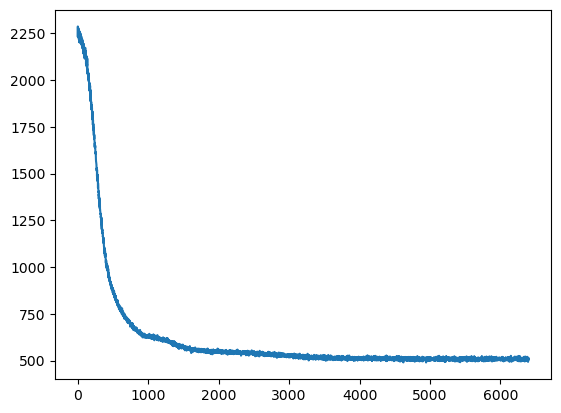

In [11]:
plt.plot(stitch_loss_lst_lst[-1])

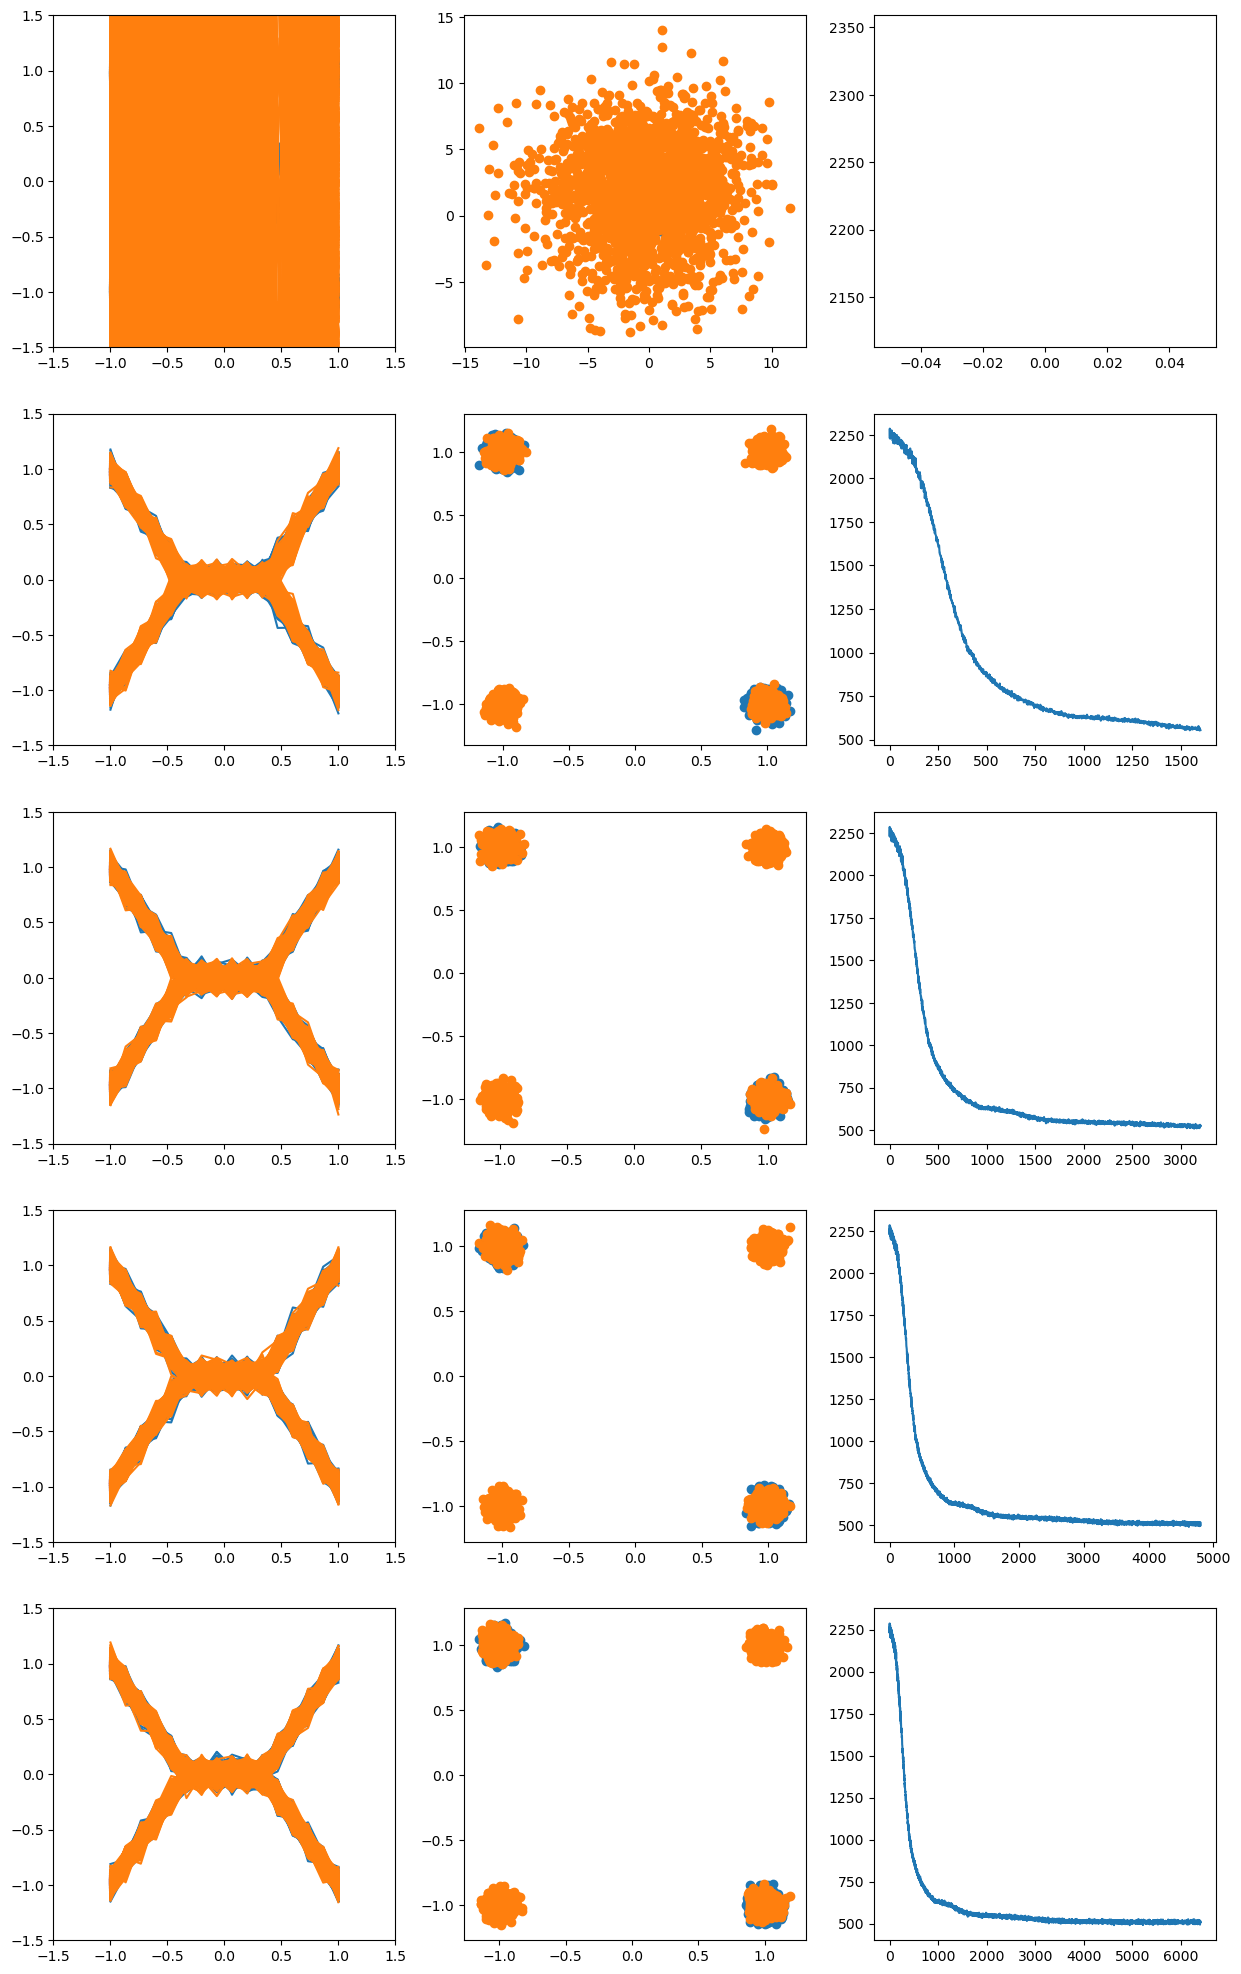

In [12]:
# Plot the sampled trajectory and its datapoit on R^T space

fig, ax = plt.subplots(len(stitch_loss_lst_lst), 3, figsize=(15, 5*len(stitch_loss_lst_lst)))

for i, (loss_lst, sampled_trajectories) in enumerate(zip(stitch_loss_lst_lst, stitch_sampled_trajectories_lst)):

    num = 0
    x = np.repeat(np.expand_dims(np.linspace(-1, 1, sampled_trajectories.shape[1]), axis=0), [sampled_trajectories.shape[0]], axis=0)[num:]
    trajectories = get_data(sampled_trajectories.shape[0])[num:]
    sampled_trajectories = sampled_trajectories[num:]

    ax[i, 0].plot(x.T, trajectories.T, c='tab:blue');
    ax[i, 0].plot(x.T, sampled_trajectories.T, c='tab:orange');
    # ax[i, 0].axis('equal')
    ax[i, 0].set_xlim(-1.5, 1.5)
    ax[i, 0].set_ylim(-1.5, 1.5)
    axis = [0, -1]
    
    sampled_trajectories_ = extract_dimension(sampled_trajectories, axis)
    trajectories_ = extract_dimension(trajectories, axis)

    ax[i, 1].scatter(trajectories_[:, 0], trajectories_[:, 1])
    ax[i, 1].scatter(sampled_trajectories_[:, 0], sampled_trajectories_[:, 1])
    # ax[i, 1].axis('equal')
    # ax[i, 1].set_xlim(-1.5, 1.5)
    # ax[i, 1].set_ylim(-1.5, 1.5)
    
    ax[i, 2].plot(loss_lst)
    


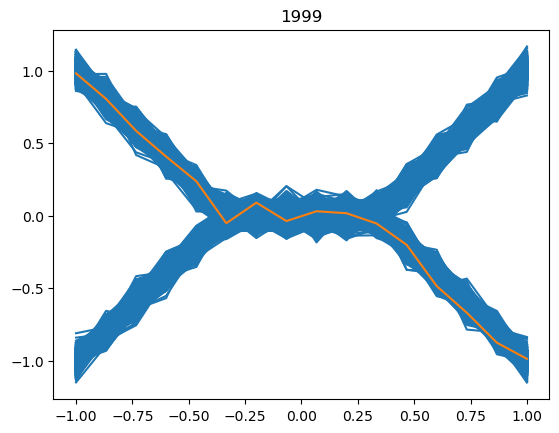

In [13]:
x = np.repeat(np.expand_dims(np.linspace(-1, 1, sampled_trajectories.shape[1]), axis=0), [sampled_trajectories.shape[0]], axis=0)
n = int(np.random.uniform(0, len(sampled_trajectories)))
plt.plot(x.T, trajectories.T, c='tab:blue');
plt.plot(x[0], sampled_trajectories[n], c='tab:orange');
plt.title(n);

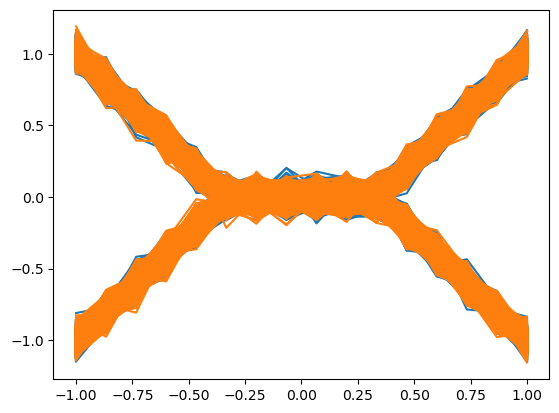

In [14]:
# sample from model
x0 = torch.randn_like(train_data)

def get_score(x):
    total_score = torch.zeros_like(x).to(x.device)
    for t in range(T-1):
        joint_energy_model = joint_energy_model_lst[t]
        marginal_energy_model = marginal_energy_model_lst[t]

        joint_energy_model_input = x[:, [t, t+1]].clone().requires_grad_()
        joint_energy = joint_energy_model(joint_energy_model_input)
        joint_score = -grad(joint_energy.sum(), joint_energy_model_input, create_graph=True)[0]
        
        marginal_score = torch.zeros_like(joint_score)
        marginal_energy_input = x[:, t:t+1].clone().requires_grad_()
        marginal_energy = marginal_energy_model(marginal_energy_input)
        # marginal_score = -grad(marginal_energy.sum(), marginal_energy_input, create_graph=True)[0] # uncomment this to see buged result
        marginal_score[:, [0]] = -grad(marginal_energy.sum(), marginal_energy_input, create_graph=True)[0] # uncomment this to see ordinary result
        
        total_score[:, [t, t+1]] += (joint_score - marginal_score)
        
        if t == 0:
            total_score[:, [t, t+1]] += marginal_score
    return total_score.clone().detach()

stitch_sampled_trajectories = langevin_sampler.sample_from_score(x0, get_score)

plt.plot(x.T, trajectories.T, c='tab:blue');
plt.plot(x.T, sampled_trajectories.T, c='tab:orange');

1. 왜 trajectory가 순간이동하는지 원인 찾기 (아마 NCSN으로 해결할 수 있을거란 뇌피셜이 있음)
2. NCSN으로 구현해보기

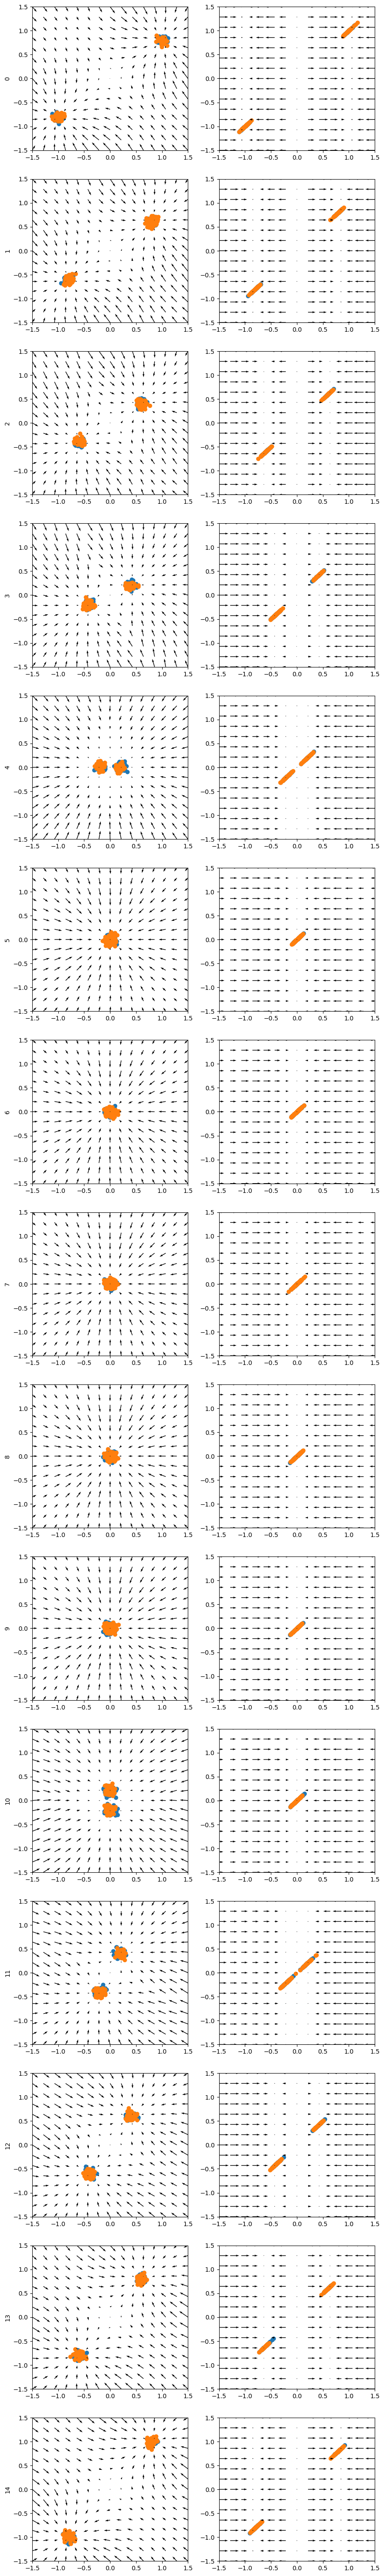

In [15]:
trajectories = get_data(128)

# Bring LangevinSampler
langevin_sampler_validate = LangevinSampler(n_step=1000, stepsize=0.01, noise_std=0.05)
T = trajectories.shape[1]

fig, ax = plt.subplots(T-1, 2, figsize=(10, 5* (T-1)))

for t in range(T-1):

    trajectories_slice = trajectories[:, [t, t+1]]
    joint_energy_model = joint_energy_model_lst[t]
    marginal_energy_model = marginal_energy_model_lst[t]

    # sample data
    x0 = torch.randn_like(torch.tensor(trajectories_slice, dtype=torch.float32)).to(device=device)

    def get_joint_score(x):
        
        joint_energy_model_input = x.clone().requires_grad_()
        joint_energy = joint_energy_model(joint_energy_model_input)
        joint_score = -grad(joint_energy.sum(), joint_energy_model_input, create_graph=True)[0]
        
        marginal_energy_input = x[:,0:1].clone().requires_grad_()
        marginal_energy = marginal_energy_model(marginal_energy_input)
        marginal_score = -grad(marginal_energy.sum(), marginal_energy_input, create_graph=True)[0]
        
        # total_score[:, [t, t+1]] += (joint_score - marginal_score)
        
        # if t == 0:
        #     total_score[:, [t, t+1]] += marginal_score

        return joint_score.clone().detach()

    def get_marginal_score(x):
        
        marginal_energy_input = x[:,0:1].clone().requires_grad_()
        marginal_energy = marginal_energy_model(marginal_energy_input)
        marginal_score = -grad(marginal_energy.sum(), marginal_energy_input, create_graph=True)[0]
        
        # total_score[:, [t, t+1]] += (joint_score - marginal_score)
        
        # if t == 0:
        #     total_score[:, [t, t+1]] += marginal_score

        return marginal_score.clone().detach()

    sampled_joint_datapoint = langevin_sampler_validate.sample_from_score(x0, get_joint_score).clone().detach().cpu().numpy()

    sampled_marginal_datapoint = langevin_sampler_validate.sample_from_score(x0, get_marginal_score).clone().detach().cpu().numpy()

    x_lim = [-1.5, 1.5]
    y_lim = [-1.5, 1.5]
    x_grid, y_grid = np.meshgrid(np.linspace(*x_lim, 15), np.linspace(*y_lim, 15))
    
    grid_input = torch.tensor(np.stack([x_grid, y_grid], axis=-1).reshape((-1, 2)), dtype=torch.float32, device=device)
    score = get_joint_score(grid_input).reshape((*x_grid.shape, 2)).cpu().numpy()
    ax[t][0].scatter(trajectories_slice[:, 0], trajectories_slice[:, 1], c='tab:blue')
    ax[t][0].scatter(sampled_joint_datapoint[:, 0], sampled_joint_datapoint[:, 1], c='tab:orange')
    ax[t][0].quiver(x_grid, y_grid, score[:, :, 0], score[:, :, 1])
    ax[t][0].set_xlim(*x_lim)
    ax[t][0].set_ylim(*y_lim)
    ax[t][0].set_ylabel(f"{t}")
    
    grid_input = torch.tensor(np.stack([x_grid, y_grid], axis=-1).reshape((-1, 2)), dtype=torch.float32, device=device)
    score = get_marginal_score(grid_input).reshape((*x_grid.shape, 1)).cpu().numpy()
    ax[t][1].scatter(trajectories_slice[:, 0], trajectories_slice[:, 0], c='tab:blue')
    ax[t][1].scatter(sampled_marginal_datapoint[:, 0], sampled_marginal_datapoint[:, 0], c='tab:orange')
    ax[t][1].quiver(x_grid, y_grid, score[:, :, 0], np.zeros_like(score[:, :, 0]))
    ax[t][1].set_xlim(*x_lim)
    ax[t][1].set_ylim(*y_lim)
    
plt.show()

In [ ]:
# compare score function btw DSM and stitched DSM

def get_stitch_score(x):
    total_score = torch.zeros_like(x).to(x.device)
    for t in range(T-1):
        joint_energy_model = joint_energy_model_lst[t]
        marginal_energy_model = marginal_energy_model_lst[t]

        joint_energy_model_input = x[:, [t, t+1]].clone().requires_grad_()
        joint_energy = joint_energy_model(joint_energy_model_input)
        joint_score = -grad(joint_energy.sum(), joint_energy_model_input, create_graph=True)[0]
        
        marginal_energy_input = x[:, t:t+1].clone().requires_grad_()
        marginal_energy = marginal_energy_model(marginal_energy_input)
        marginal_score = -grad(marginal_energy.sum(), marginal_energy_input, create_graph=True)[0]
        
        total_score[:, [t, t+1]] += (joint_score - marginal_score)
        
        if t == 0:
            total_score[:, [t, t+1]] += marginal_score
    return total_score.clone().detach()

def get_dsm_score(x):
    
    energy_input = x.clone().requires_grad_()
    energy = energy_model(energy_input)
    return (-grad(energy.sum(), energy_input, create_graph=True)[0]).clone().detach()


In [ ]:
x0 = torch.zeros(1, T).to(device)
print(get_stitch_score(x0))
print(get_dsm_score(x0))

In [ ]:
# # plot vectory field
# mesh_grid_input = [np.linspace(-1, 1, 5) for _ in range(T)]

# dv = np.meshgrid(*mesh_grid_input)
# dv = [arr.reshape((1, -1)).squeeze() for arr in dv]
# mesh_grid = torch.tensor(np.stack(dv, axis=1), dtype=torch.float32, device=device)

# dsm_score_vec_field = get_dsm_score(mesh_grid).cpu().numpy()
# stitch_score_vec_field = get_stitch_score(mesh_grid).cpu().numpy()

# fig, ax = plt.subplots(2, T-1, figsize=(5*(T-1), 10))

# scale = 0.003
# for t in range(T-1):

#     plotx = np.tile(mesh_grid.clone().cpu().detach().numpy()[:, t:t+1], 2)
#     plotx[:, 1] += scale * dsm_score_vec_field[:, t]
#     ploty = np.tile(mesh_grid.clone().cpu().detach().numpy()[:, t+1:t+2], 2)
#     ploty[:, 1] += scale * dsm_score_vec_field[:, t+1] 
#     ax[0][t].plot(plotx.T, ploty.T, c='tab:gray')
    
#     plotx = np.tile(mesh_grid.clone().cpu().detach().numpy()[:, t:t+1], 2)
#     plotx[:, 1] += scale * stitch_score_vec_field[:, t]
#     ploty = np.tile(mesh_grid.clone().cpu().detach().numpy()[:, t+1:t+2], 2)
#     ploty[:, 1] += scale * stitch_score_vec_field[:, t+1] 
#     ax[1][t].plot(plotx.T, ploty.T, c='tab:gray')

In [ ]:
print(dv)
print(len(dv))

print(dv)
print(mesh_grid)